In [1]:
from train_shap import get_model_data_for_shap, get_data_for_Shap
import shap
import joblib
# beA3o82D_1112_1_all
# fmodel, params, pp, fp= get_model_data_for_shap('trainshap_timeseries.yaml', 'beA3o82D', 1112)
fmodel, params, pp, fp= get_model_data_for_shap('trainshap_timeseries.yaml', '43KOTlpS', 186) # 43KOTlpS_186_1_all
# fmodel, params, pp, fp= get_model_data_for_shap('trainshap_timeseries.yaml', 'lKesaFNR', 31) # lKesaFNR_31_extval_gr1
   

2024-10-23 22:37:16.971 | INFO     | preprocessor:_dropna:160 - Dropping NaN values
2024-10-23 22:37:17.219 | INFO     | preprocessor:_dropna:184 - Columns with NaN values: Index(['Hematocrit_Avg_preclinical', 'Hematocrit_Avg_acute',
       'Hematocrit_Avg_chronic', 'LymphocytesPercentage_Avg_preclinical',
       'LymphocytesPercentage_Avg_acute', 'LymphocytesPercentage_Avg_chronic',
       'NeutrophilsPercentage_Avg_preclinical',
       'NeutrophilsPercentage_Avg_acute', 'NeutrophilsPercentage_Avg_chronic',
       'MonocytesPercentage_Avg_preclinical',
       ...
       'Crab_Avg_chronic', 'MixedGrasses_Avg_preclinical',
       'MixedGrasses_Avg_acute', 'MixedGrasses_Avg_chronic',
       'Mugwort_Avg_preclinical', 'Mugwort_Avg_acute', 'Mugwort_Avg_chronic',
       'Salmon_Avg_preclinical', 'Salmon_Avg_acute', 'Salmon_Avg_chronic'],
      dtype='object', length=233)
2024-10-23 22:37:17.224 | INFO     | preprocessor:_imputation:196 - Imputing missing values
2024-10-23 22:37:18.390 | INF

[0]	train-rmsle:1.54913	train-loss:228507.51562	validation-rmsle:1.57716	validation-loss:266995.62500
[1]	train-rmsle:1.50141	train-loss:228446.28125	validation-rmsle:1.52881	validation-loss:266927.18750
[2]	train-rmsle:1.45508	train-loss:228378.09375	validation-rmsle:1.48181	validation-loss:266850.93750
[3]	train-rmsle:1.40970	train-loss:228300.35938	validation-rmsle:1.43551	validation-loss:266763.75000
[4]	train-rmsle:1.36631	train-loss:228215.54688	validation-rmsle:1.39138	validation-loss:266668.90625
[5]	train-rmsle:1.32434	train-loss:228120.79688	validation-rmsle:1.34854	validation-loss:266562.65625
[6]	train-rmsle:1.28407	train-loss:228015.34375	validation-rmsle:1.30745	validation-loss:266444.65625
[7]	train-rmsle:1.24543	train-loss:227897.78125	validation-rmsle:1.26793	validation-loss:266313.12500
[8]	train-rmsle:1.20845	train-loss:227766.76562	validation-rmsle:1.23004	validation-loss:266166.50000
[9]	train-rmsle:1.17317	train-loss:227620.79688	validation-rmsle:1.19380	validatio

In [25]:
from utils import reverse_y_scaling
key = 'all'
keyname = 'all'
k = 100
rowna = 0.5
X, y = get_data_for_Shap(fmodel, fp, params.copy(), 
                        row_na_threshold = rowna,
                        preprocessor = pp, 
                        k = k, 
                        randomrate= 0.2,
                        pick_key= key)
y = reverse_y_scaling(y, params['scale_factor'], params['log_transform'])


2024-10-23 22:55:55.787 | INFO     | preprocessor:_dropna:160 - Dropping NaN values
2024-10-23 22:55:55.945 | INFO     | preprocessor:_dropna:184 - Columns with NaN values: Index(['Hematocrit_Avg_preclinical', 'Hematocrit_Avg_acute',
       'Hematocrit_Avg_chronic', 'LymphocytesPercentage_Avg_preclinical',
       'LymphocytesPercentage_Avg_acute', 'LymphocytesPercentage_Avg_chronic',
       'NeutrophilsPercentage_Avg_preclinical',
       'NeutrophilsPercentage_Avg_acute', 'NeutrophilsPercentage_Avg_chronic',
       'MonocytesPercentage_Avg_preclinical',
       ...
       'Crab_Avg_chronic', 'MixedGrasses_Avg_preclinical',
       'MixedGrasses_Avg_acute', 'MixedGrasses_Avg_chronic',
       'Mugwort_Avg_preclinical', 'Mugwort_Avg_acute', 'Mugwort_Avg_chronic',
       'Salmon_Avg_preclinical', 'Salmon_Avg_acute', 'Salmon_Avg_chronic'],
      dtype='object', length=233)
2024-10-23 22:55:55.948 | INFO     | preprocessor:_imputation:196 - Imputing missing values
2024-10-23 22:55:56.751 | INF

In [26]:
from plot_shap import get_shap_values
from train_shap import ModelReversingY
# for correlation
shap_values, X = get_shap_values(X, ModelReversingY(fmodel, params), 300)


PermutationExplainer explainer: 301it [00:35,  6.13it/s]                         


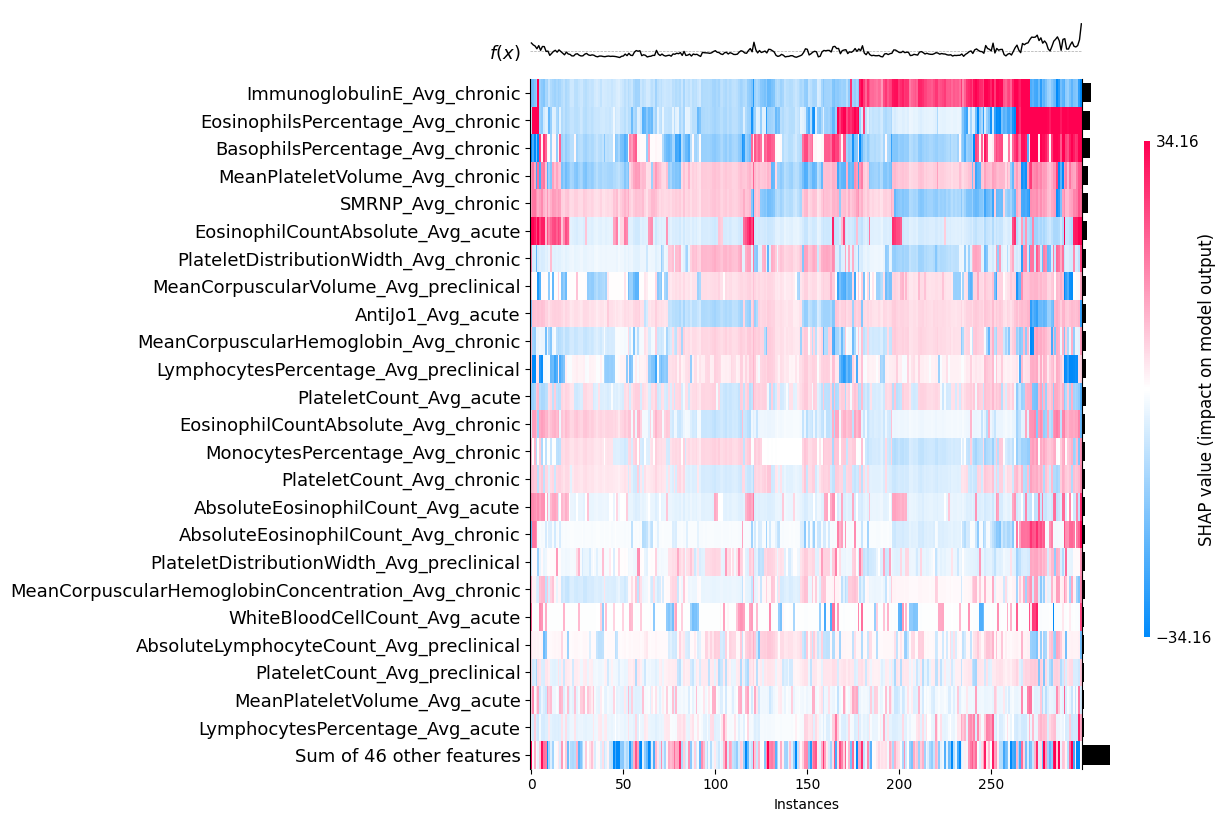

In [28]:
ax = shap.plots.heatmap(shap_values, max_display=25, 
                        # instance_order=shap_values.sum(1),
                        show = False)
# 获取 Figure 对象
ax.set_aspect(15) 
fig = ax.get_figure()


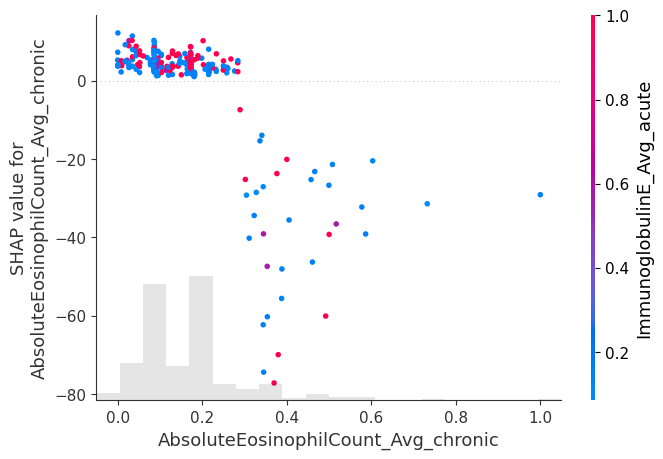

In [9]:
shap.plots.scatter(shap_values[:, "AbsoluteEosinophilCount_Avg_chronic"], 
                   color=shap_values[:, "ImmunoglobulinE_Avg_acute"],
                   x_jitter=5
                   )
